In [1]:
from imutils import contours
import numpy as np
import argparse
import imutils
import matplotlib.pyplot as plt
import cv2

In [2]:
# construct the argument parser and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--image", required=True,
	help="path to input image")
ap.add_argument("-r", "--reference", required=True,
	help="path to reference OCR-A image")
args = vars(ap.parse_args())

usage: ipykernel_launcher.py [-h] -i IMAGE -r REFERENCE
ipykernel_launcher.py: error: the following arguments are required: -i/--image, -r/--reference


SystemExit: 2

/home/tin/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3426: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [3]:
# define a dictionary that maps the first digit of a credit card
# number to the credit card type
FIRST_NUMBER = {
	"3": "American Express",
	"4": "Visa",
	"5": "MasterCard",
	"6": "Discover Card"
}

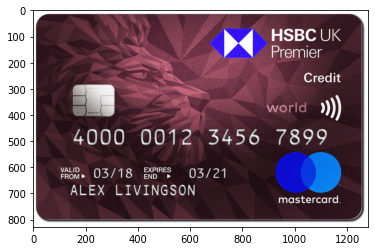

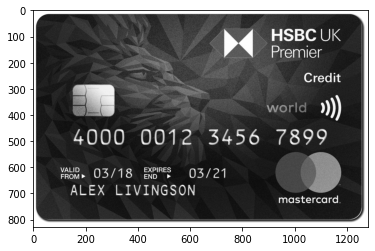

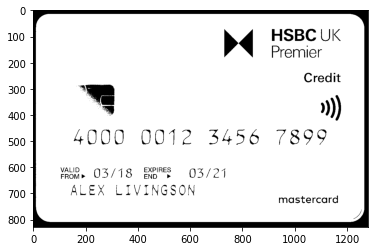

In [4]:
# load the reference OCR-A image from disk, convert it to grayscale,
# and threshold it, such that the digits appear as *white* on a
# *black* background
# and invert it, such that the digits appear as *white* on a *black*
ref = cv2.imread('./images/1.jpg')
# print(ref)
plt.imshow(ref)
plt.show()

ref = cv2.cvtColor(ref, cv2.COLOR_BGR2GRAY)
plt.imshow(ref,cmap='gray')
plt.show()
ref = cv2.threshold(ref, 200, 60, cv2.THRESH_BINARY_INV)[1]
plt.imshow(ref,cmap='gray')
plt.show()



In [5]:
# find contours in the OCR-A image (i.e,. the outlines of the digits)
# sort them from left to right, and initialize a dictionary to map
# digit name to the ROI
refCnts = cv2.findContours(ref.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
refCnts = imutils.grab_contours(refCnts)
refCnts = contours.sort_contours(refCnts, method="left-to-right")[0]
digits = {}

In [6]:
# loop over the OCR-A reference contours
for (i, c) in enumerate(refCnts):
	# compute the bounding box for the digit, extract it, and resize
	# it to a fixed size
	(x, y, w, h) = cv2.boundingRect(c)
	roi = ref[y:y + h, x:x + w]
	roi = cv2.resize(roi, (57, 88))
	# update the digits dictionary, mapping the digit name to the ROI
	digits[i] = roi

In [7]:
# initialize a rectangular (wider than it is tall) and square
# structuring kernel
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 3))
sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))

In [8]:
# load the input image, resize it, and convert it to grayscale
image = cv2.imread('./images/1.jpg')
image = imutils.resize(image, width=300)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [9]:
# apply a tophat (whitehat) morphological operator to find light
# regions against a dark background (i.e., the credit card numbers)
tophat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, rectKernel)

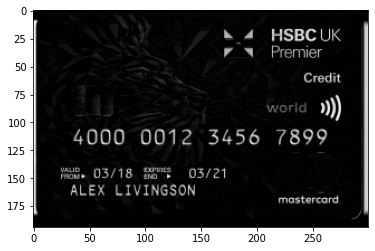

In [11]:
plt.imshow(tophat,cmap='gray')
plt.show()

In [12]:
# compute the Scharr gradient of the tophat image, then scale
# the rest back into the range [0, 255]
gradX = cv2.Sobel(tophat, ddepth=cv2.CV_32F, dx=1, dy=0,
	ksize=-1)
gradX = np.absolute(gradX)
(minVal, maxVal) = (np.min(gradX), np.max(gradX))
gradX = (255 * ((gradX - minVal) / (maxVal - minVal)))
gradX = gradX.astype("uint8")

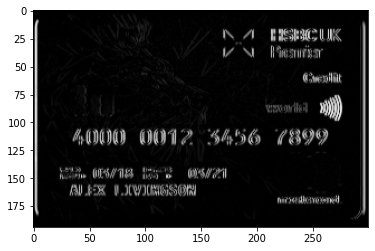

In [13]:
plt.imshow(gradX,cmap='gray')
plt.show()

In [14]:
# apply a closing operation using the rectangular kernel to help
# cloes gaps in between credit card number digits, then apply
# Otsu's thresholding method to binarize the image
gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKernel)
thresh = cv2.threshold(gradX, 0, 255,
	cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
# apply a second closing operation to the binary image, again
# to help close gaps between credit card number regions
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, sqKernel)

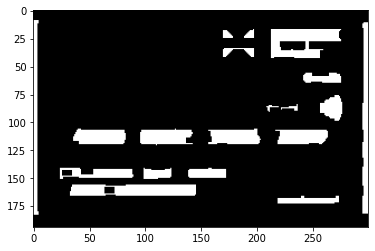

In [15]:
plt.imshow(thresh,cmap='gray')
plt.show()

In [106]:
# find contours in the thresholded image, then initialize the
# list of digit locations
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
locs = []

In [107]:
# loop over the contours
for (i, c) in enumerate(cnts):
	# compute the bounding box of the contour, then use the
	# bounding box coordinates to derive the aspect ratio
	(x, y, w, h) = cv2.boundingRect(c)
	ar = w / float(h)
	# since credit cards used a fixed size fonts with 4 groups
	# of 4 digits, we can prune potential contours based on the
	# aspect ratio
	if ar > 2.5 and ar < 4.0:
		# contours can further be pruned on minimum/maximum width
		# and height
		if (w > 40 and w < 55) and (h > 10 and h < 20):
			# append the bounding box region of the digits group
			# to our locations list
			locs.append((x, y, w, h))

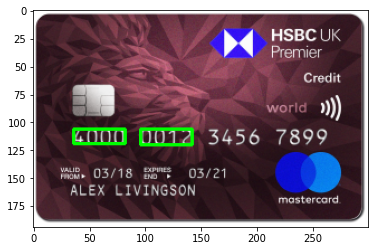

In [105]:


image = cv2.imread('./images/1.jpg')
image = imutils.resize(image, width=300)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

cv2.rectangle(image,locs[0],(0,255,0),2)
cv2.rectangle(image,locs[1],(0,255,0),2)
cv2.rectangle(image,locs[2],(0,255,0),2)
cv2.rectangle(image,locs[3],(0,255,0),2)

plt.imshow(image,cmap='gray')
plt.show()

In [101]:
# sort the digit locations from left-to-right, then initialize the
# list of classified digits
locs = sorted(locs, key=lambda x:x[0])
output = []
print(locs[0])
print(locs)

(36, 106, 47, 14)
[(36, 106, 47, 14), (36, 106, 47, 14), (96, 106, 47, 15), (96, 106, 47, 15), (157, 106, 47, 14), (157, 106, 47, 14), (217, 107, 47, 13), (217, 107, 47, 13)]


In [98]:
# loop over the 4 groupings of 4 digits
for (i, (gX, gY, gW, gH)) in enumerate(locs):
    # initialize the list of group digits
    print(i)
    groupOutput = []
    # extract the group ROI of 4 digits from the grayscale image,
    # then apply thresholding to segment the digits from the
    # background of the credit card
    group = gray[gY - 5:gY + gH + 5, gX - 5:gX + gW + 5]
    group = cv2.threshold(group, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    # detect the contours of each individual digit in the group,
    # then sort the digit contours from left to right
    digitCnts = cv2.findContours(group.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    digitCnts = imutils.grab_contours(digitCnts)
    digitCnts = contours.sort_contours(digitCnts, method="left-to-right")[0]
    groupOutput.append(digitCnts)

0
1
2
3
4
5
6
7


[(array([[[ 6,  5]],

       [[11,  5]],

       [[12,  6]],

       [[12,  7]],

       [[11,  8]],

       [[11,  9]],

       [[ 9, 11]],

       [[ 9, 13]],

       [[ 8, 14]],

       [[ 8, 17]],

       [[ 9, 17]],

       [[ 9, 13]],

       [[10, 12]],

       [[10, 11]],

       [[12,  9]],

       [[12,  8]],

       [[14,  6]],

       [[14,  5]]], dtype=int32), array([[[22,  4]],

       [[21,  5]],

       [[20,  5]],

       [[19,  6]],

       [[19,  9]],

       [[20, 10]],

       [[20, 11]],

       [[18, 13]],

       [[18, 16]],

       [[19, 17]],

       [[20, 17]],

       [[21, 18]],

       [[22, 17]],

       [[24, 17]],

       [[26, 15]],

       [[26, 12]],

       [[24, 10]],

       [[24,  9]],

       [[25,  8]],

       [[25,  5]],

       [[23,  5]]], dtype=int32), array([[[33,  4]],

       [[30,  7]],

       [[30, 10]],

       [[31, 11]],

       [[31, 12]],

       [[33, 12]],

       [[35, 14]],

       [[32, 17]],

       [[33, 17]],

       [[3

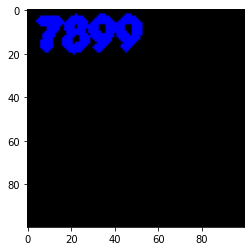

In [100]:
# plt.imshow(digitCnts[0])
# plt.show()
# print(digitCnts)
print(groupOutput)
image = cv2.imread('./images/1.jpg')
blank_image = np.zeros((100,100,3), np.uint8)
image = imutils.resize(image, width=300)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2.drawContours(blank_image,groupOutput[0],-1,(0,0,255),3)
plt.imshow(blank_image,cmap='gray')
plt.show()